<a href="https://colab.research.google.com/github/LucasAfa/Projeto2-IF775/blob/main/projeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math

from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn import linear_model, ensemble, datasets, model_selection, preprocessing as pre
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import sklearn.metrics
from sklearn.metrics import r2_score

import matplotlib as mpl

!pip install optuna --quiet
import optuna

In [2]:
!pip install mlflow --quiet
!pip install pyngrok --quiet

import mlflow

with mlflow.start_run(run_name="MLflow on Colab"):
  mlflow.log_metric("m1", 2.0)
  mlflow.log_param("p1", "mlflow-colab")

# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background


# create remote tunnel using ngrok.com to allow local port access
# borrowed from https://colab.research.google.com/github/alfozan/MLflow-GBRT-demo/blob/master/MLflow-GBRT-demo.ipynb#scrollTo=4h3bKHMYUIG6

from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = ""
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000/
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://7b0a63e1ddd8.ngrok.io


In [3]:
#Pegando o csv que será usado para as analises
#É um csv que contém informações sobre todos os jogadores de futebol presentes no jogo Fifa 20
fifa20=pd.read_csv("https://raw.githubusercontent.com/LucasAfa/Projeto2-IF775/main/players_20.csv", header=0)
print(fifa20)

       sofifa_id                                         player_url  ...   rcb    rb
0         158023  https://sofifa.com/player/158023/lionel-messi/...  ...  52+2  63+2
1          20801  https://sofifa.com/player/20801/c-ronaldo-dos-...  ...  53+3  61+3
2         190871  https://sofifa.com/player/190871/neymar-da-sil...  ...  46+3  61+3
3         200389  https://sofifa.com/player/200389/jan-oblak/20/...  ...   NaN   NaN
4         183277  https://sofifa.com/player/183277/eden-hazard/2...  ...  49+3  61+3
...          ...                                                ...  ...   ...   ...
18273     245006  https://sofifa.com/player/245006/shuai-shao/20...  ...  46+2  45+2
18274     250995  https://sofifa.com/player/250995/mingjie-xiao/...  ...  47+2  46+2
18275     252332  https://sofifa.com/player/252332/wei-zhang/20/...  ...  49+2  47+2
18276     251110  https://sofifa.com/player/251110/haijian-wang/...  ...  49+2  48+2
18277     233449  https://sofifa.com/player/233449/ximing-pan/20.

In [4]:
#Não pretendemos analisar os goleiros, pois muitas colunas deles são vazias e ter que inputar dados em todas elas não soa muito interessante pra gente
fifa20 = fifa20[(fifa20.team_position != "GK")]
fifa20.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,...,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,94,94,95500000,565000,"RW, CF, ST",Left,5,4,4,Medium/Low,Messi,Yes,195800000.0,"#Dribbler, #Distance Shooter, #Crosser, #FK Sp...",RW,10.0,NaN,2004-07-01,2021.0,NaN,NaN,87.0,92.0,92.0,96.0,39.0,66.0,NaN,NaN,NaN,...,48,40,94,94,75,96,33,37,26,6,11,15,14,8,89+2,89+2,89+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,92+2,87+2,87+2,87+2,92+2,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,93,93,58500000,405000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,96500000.0,"#Speedster, #Dribbler, #Distance Shooter, #Acr...",LW,7.0,NaN,2018-07-10,2022.0,LS,7.0,90.0,93.0,82.0,89.0,35.0,78.0,NaN,NaN,NaN,...,63,29,95,82,85,95,28,32,24,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,92,92,105500000,290000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,195200000.0,"#Speedster, #Dribbler, #Playmaker , #Crosser,...",CAM,10.0,NaN,2017-08-03,2022.0,LW,10.0,91.0,85.0,87.0,95.0,32.0,58.0,NaN,NaN,NaN,...,51,36,87,90,90,94,27,26,29,9,9,15,15,11,84+3,84+3,84+3,90+3,89+3,89+3,89+3,90+3,90+3,90+3,90+3,89+3,82+3,82+3,82+3,89+3,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,91,91,90000000,470000,"LW, CF",Right,4,4,4,High/Medium,Normal,Yes,184500000.0,"#Speedster, #Dribbler, #Acrobat",LW,7.0,NaN,2019-07-01,2024.0,LF,10.0,91.0,83.0,86.0,94.0,35.0,66.0,NaN,NaN,NaN,...,54,41,87,89,88,91,34,27,22,11,12,6,8,8,83+3,83+3,83+3,89+3,88+3,88+3,88+3,89+3,89+3,89+3,89+3,89+3,83+3,83+3,83+3,89+3,66+3,63+3,63+3,63+3,66+3,61+3,49+3,49+3,49+3,61+3
5,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,Kevin De Bruyne,28,1991-06-28,181,70,Belgium,Manchester City,91,91,90000000,370000,"CAM, CM",Right,4,5,4,High/High,Normal,Yes,166500000.0,"#Dribbler, #Playmaker , #Engine, #Distance Sh...",RCM,17.0,NaN,2015-08-30,2023.0,RCM,7.0,76.0,86.0,92.0,86.0,61.0,78.0,NaN,NaN,NaN,...,76,61,88,94,79,91,68,58,51,15,13,5,10,13,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3


In [5]:
#Tornando algumas colunas categóricas e encodando elas, pois podem ser relevantes para a analise
fifa20['nationality'] = fifa20['nationality'].astype('category')
fifa20['club'] = fifa20['club'].astype('category')
fifa20['team_position'] = fifa20['team_position'].astype('category')

fifa20['team_position'] = fifa20['team_position'].cat.codes
fifa20['country_code'] = fifa20['nationality'].cat.codes
fifa20['club_code'] = fifa20['club'].cat.codes

fifa20 = fifa20._get_numeric_data()


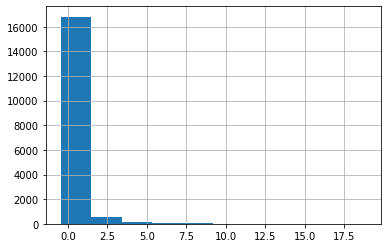

In [6]:
#Pretendemos fazer a predição do valor do jogador, e para isso precisamos desse valor normalizado
fifa20['price_norm'] = (fifa20['value_eur'] - fifa20['value_eur'].mean()) / (fifa20['value_eur'].std())
fifa20.price_norm.hist()

In [7]:
#Aqui estamos dropando colunas com 70% dos dados ausentes que não serão relevantes 
fifa20 = fifa20.dropna(thresh=0.7*len(fifa20), axis=1)
fifa20.describe


<bound method NDFrame.describe of        sofifa_id  age  height_cm  ...  country_code  club_code  price_norm
0         158023   32        170  ...             5        224   17.005348
1          20801   34        187  ...           120        350   10.244419
2         190871   27        175  ...            18        462   18.832626
4         183277   28        175  ...            12        505   16.000345
5         192985   28        181  ...            12        400   16.000345
...          ...  ...        ...  ...           ...        ...         ...
18273     245006   22        186  ...            28         79   -0.437849
18274     250995   22        177  ...            28        574   -0.437849
18275     252332   19        186  ...            28        317   -0.437849
18276     251110   18        185  ...            28        573   -0.437849
18277     233449   26        182  ...            28        317   -0.437849

[17616 rows x 58 columns]>

In [8]:
#Essa coluna nos será relevante, porém possui alguns dados ausentes, então estamos preenchendo os vazios com a média
fifa20['release_clause_eur'].fillna(fifa20['release_clause_eur'].mean(), inplace=True)


In [9]:
#Vamos aqui subdivir os grupos de teste e treino de forma aleatória para o nosso dataframe usando o train_test_split
X, y = fifa20, fifa20['price_norm']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,train_size=0.8,random_state=9,)

print(f"Train labels:\n{y_train}")
print(f"Test labels:\n{y_test}")
print(f"Train labels:\n{X_train}")
print(f"Test labels:\n{X_test}")

Train labels:
11384   -0.330953
13026   -0.390340
10328   -0.308112
1789     1.108028
13140   -0.330953
           ...   
4812     0.103025
4957    -0.043157
5323    -0.285271
10501   -0.335521
564      1.473484
Name: price_norm, Length: 14092, dtype: float64
Test labels:
7605    -0.280703
369      1.016665
1530     0.742573
3821    -0.289839
13986   -0.349226
           ...   
12369   -0.340089
1537     0.742573
1488     0.925301
11669   -0.340089
7951    -0.271567
Name: price_norm, Length: 3524, dtype: float64
Train labels:
       sofifa_id  age  height_cm  ...  country_code  club_code  price_norm
11384     205145   24        183  ...           127        106   -0.330953
13026     216134   29        175  ...            40         21   -0.390340
10328     240891   23        172  ...            57        233   -0.308112
1789      206594   24        180  ...            45         99    1.108028
13140     251341   18        177  ...            53        448   -0.330953
...          ...  

In [10]:
#Aqui estamos subdividindo novamente, porém dentro dos dataframes de treino agora, para criarmos os splits de validação 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size=0.25,train_size=0.75,random_state=9,)


In [11]:
#Vamos avaliar agora as correlações, a coluna que queremos prever é a de price_norm, referente ao value_eur, que é o valor do jogador agora normalizado
#E observando encontramos as seguintes colunas relevantes: wage_eur(Salário), overall(Força atual), mentality_composure(Mentalidade),
#potential(Potencial), international_reputation(Reputação internacional), movement_reactions(Reação de movimentos)


corr = fifa20.corr()
corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r' & 'BrBG' are other good diverging colormaps

In [12]:
try:
    experiment_id_LinearRegression = mlflow.create_experiment(name="LinearRegression")
    experiment_id_RandomForest = mlflow.create_experiment(name="RandomForestRegressor")
    experiment_id_SVR = mlflow.create_experiment(name="SVR")
    experiment_id_MLP = mlflow.create_experiment(name="MLP")

except:
    experiment_id_LinearRegression = mlflow.get_experiment_by_name(name="LinearRegression").experiment_id
    experiment_id_RandomForest = mlflow.get_experiment_by_name(name="RandomForestRegressor").experiment_id
    experiment_id_SVR = mlflow.get_experiment_by_name(name="SVR").experiment_id
    experiment_id_MLP = mlflow.get_experiment_by_name(name="MLP").experiment_id

In [13]:
#Vamos começar a importar as coisas que serão usadas para a precdição, incluindo o optuna 


In [14]:
'''Estávamos tendo problemas de r2 negativo no MLP, ao pesquisar para resolver encontramos que o possível motivo seria normalização dos dados. 
Era recomendado o uso do Standard Scaler para fazer isto de maneira rápida e precisa e seu uso resolveu este problema. 
Após usá-lo para o MLP, percebemos que pela natureza vetorial do SVR ele também se beneficiaria de tal mudança pela normalização facilitar a 
inserção de perceptrons com boa separação dos dados e resolvemos deixar os dados normalizados como o padrão pelo Standard Scaler
'''
columns = ['wage_eur', 'overall','mentality_composure','potential','international_reputation','movement_reactions']

scaler = pre.StandardScaler()
X_train = scaler.fit_transform(X_train[columns])
X_val = scaler.fit_transform(X_val[columns])



R2:      0.786
MSE:     0.180
MAE:     0.235


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



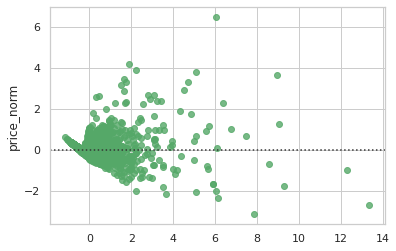

In [15]:
#Como nossa predição é quantitativa, precisamos de algoritmos de regressão, vamos começar com o clássico de regressão linear

model = LinearRegression()
model.fit(X_train, y_train)
predict = model.predict(X_val)
mse = sklearn.metrics.mean_squared_error(y_val, predict)
r2 = r2_score(y_val, predict)
error_MAE = sklearn.metrics.mean_absolute_error(y_val, predict)

print("R2:      {:.3f}".format(r2))
print("MSE:     {:.3f}".format(mse))
print("MAE:     {:.3f}".format(error_MAE))
sns.set(style="whitegrid")
sns.residplot(predict, y_val, color="g")
#calcular mape, male

In [16]:
#Agora vamos melhorar a taxa de erros da regressão linear utilizando o Optuna

def linearObjective(trial):
    alpha = trial.suggest_uniform('alpha', 0.0, 2.0)
    model = sklearn.linear_model.Lasso(alpha=alpha)
    with mlflow.start_run(experiment_id=experiment_id_LinearRegression) as run:
      model.fit(X_train, y_train)
      y_pred = model.predict(X_val)
      error_MSE = sklearn.metrics.mean_squared_error(y_val, y_pred)
      error_MAE = sklearn.metrics.mean_absolute_error(y_val, y_pred)
      r2 = r2_score(y_val, predict)
      mlflow.log_param("alpha", str(alpha))
      mlflow.log_metric('mean_squared_error', error_MSE)
      mlflow.log_metric('mean_absolute_error', error_MAE)
      mlflow.log_metric('r2_score', r2)
      mlflow.end_run()
    return error_MSE

study = optuna.create_study(direction='minimize')
study.optimize(linearObjective, n_trials=20)

print('Minimum mean squared error: ' + str(study.best_value))
print('Best parameter: ' + str(study.best_params))

[I 2020-11-15 15:17:02,220] A new study created in memory with name: no-name-1af43a04-2682-4f9d-afc5-36d826200f96
[I 2020-11-15 15:17:02,283] Trial 0 finished with value: 0.4076523300365765 and parameters: {'alpha': 0.5350135491426569}. Best is trial 0 with value: 0.4076523300365765.
[I 2020-11-15 15:17:02,346] Trial 1 finished with value: 0.843625097770656 and parameters: {'alpha': 1.6186599412315816}. Best is trial 0 with value: 0.4076523300365765.
[I 2020-11-15 15:17:02,406] Trial 2 finished with value: 0.3822673143853582 and parameters: {'alpha': 0.5044853358836416}. Best is trial 2 with value: 0.3822673143853582.
[I 2020-11-15 15:17:02,470] Trial 3 finished with value: 0.843625097770656 and parameters: {'alpha': 1.355752901542098}. Best is trial 2 with value: 0.3822673143853582.
[I 2020-11-15 15:17:02,534] Trial 4 finished with value: 0.843625097770656 and parameters: {'alpha': 1.8945107048142131}. Best is trial 2 with value: 0.3822673143853582.
[I 2020-11-15 15:17:02,598] Trial 5

Minimum mean squared error: 0.17454214974581872
Best parameter: {'alpha': 0.04705410476224392}


R2:      0.972
MSE:     0.023
MAE:     0.050


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



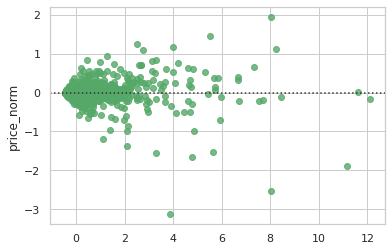

In [17]:
#Agora vamos fazer o random Forest

model1  = RandomForestRegressor()
model1.fit(X_train, y_train)

predict = model1.predict(X_val)

mse1 = sklearn.metrics.mean_squared_error(y_val, predict)
r21 = r2_score(y_val, predict)
error_MAE1 = sklearn.metrics.mean_absolute_error(y_val, predict)

print("R2:      {:.3f}".format(r21))
print("MSE:     {:.3f}".format(mse1))
print("MAE:     {:.3f}".format(error_MAE1))

sns.set(style="whitegrid")
sns.residplot(predict, y_val, color="g")

In [18]:
#Agora vamos minimizar a taxa de erros do Random Forest utilizando o optuna
def randomObjective(trial):
    rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
    model = sklearn.ensemble.RandomForestRegressor(max_depth=rf_max_depth)
    with mlflow.start_run(experiment_id=experiment_id_RandomForest) as run:
      model.fit(X_train, y_train)
      y_pred = model.predict(X_val)
      error_MSE = sklearn.metrics.mean_squared_error(y_val, y_pred)
      error_MAE = sklearn.metrics.mean_absolute_error(y_val, y_pred)
      r2 = r2_score(y_val, predict)
      mlflow.log_param("rf_max_depth", str(rf_max_depth))
      mlflow.log_metric('mean_squared_error', error_MSE)
      mlflow.log_metric('mean_absolute_error', error_MAE)
      mlflow.log_metric('r2_score', r2)
      mlflow.end_run()
    return error_MSE
study = optuna.create_study(direction="minimize")
study.optimize(randomObjective, n_trials=10)
print(study.best_trial)

[I 2020-11-15 15:17:07,024] A new study created in memory with name: no-name-4954ef84-7963-4a66-90a0-8e8d5a96fb64
[I 2020-11-15 15:17:08,578] Trial 0 finished with value: 0.023343660091645096 and parameters: {'rf_max_depth': 8}. Best is trial 0 with value: 0.023343660091645096.
[I 2020-11-15 15:17:09,142] Trial 1 finished with value: 0.10971776137908379 and parameters: {'rf_max_depth': 2}. Best is trial 0 with value: 0.023343660091645096.
[I 2020-11-15 15:17:11,870] Trial 2 finished with value: 0.024061449075641554 and parameters: {'rf_max_depth': 16}. Best is trial 0 with value: 0.023343660091645096.
[I 2020-11-15 15:17:14,462] Trial 3 finished with value: 0.02343311570421819 and parameters: {'rf_max_depth': 15}. Best is trial 0 with value: 0.023343660091645096.
[I 2020-11-15 15:17:15,523] Trial 4 finished with value: 0.02860522472986286 and parameters: {'rf_max_depth': 5}. Best is trial 0 with value: 0.023343660091645096.
[I 2020-11-15 15:17:16,258] Trial 5 finished with value: 0.052

FrozenTrial(number=0, value=0.023343660091645096, datetime_start=datetime.datetime(2020, 11, 15, 15, 17, 7, 29737), datetime_complete=datetime.datetime(2020, 11, 15, 15, 17, 8, 578090), params={'rf_max_depth': 8}, distributions={'rf_max_depth': IntLogUniformDistribution(high=32, low=2, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE)


R2:      0.921
MSE:     0.067
MAE:     0.095


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



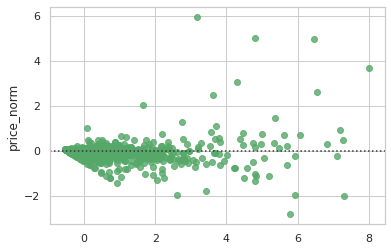

In [19]:
#Agora vamos fazer o SVR

model2  = SVR()
model2.fit(X_train, y_train)

predict = model2.predict(X_val)

mse2 = sklearn.metrics.mean_squared_error(y_val, predict)
r22 = r2_score(y_val, predict)
error_MAE2 = sklearn.metrics.mean_absolute_error(y_val, predict)

print("R2:      {:.3f}".format(r22))
print("MSE:     {:.3f}".format(mse2))
print("MAE:     {:.3f}".format(error_MAE2))

sns.set(style="whitegrid")
sns.residplot(predict, y_val, color="g")

In [20]:
#Agora vamos melhorar a acurácia do SVR no optuna
def svrObjective(trial):
    svr_c = trial.suggest_loguniform('svr_c', 1e-3, 1e3)
    model = SVR(C=svr_c)
    with mlflow.start_run(experiment_id=experiment_id_SVR) as run:
      model.fit(X_train, y_train)
      y_pred = model.predict(X_val)
      error_MSE = sklearn.metrics.mean_squared_error(y_val, y_pred)
      error_MAE = sklearn.metrics.mean_absolute_error(y_val, y_pred)
      r2 = r2_score(y_val, predict)
      mlflow.log_param("svr_c", str(svr_c))
      mlflow.log_metric('mean_squared_error', error_MSE)
      mlflow.log_metric('mean_absolute_error', error_MAE)
      mlflow.log_metric('r2_score', r2)
      mlflow.end_run()
    return error_MSE

study = optuna.create_study(direction="minimize")
study.optimize(svrObjective, n_trials=10)
print(study.best_trial)

[I 2020-11-15 15:17:26,440] A new study created in memory with name: no-name-b353bc97-6764-4597-8679-3350f708875a
[I 2020-11-15 15:17:28,020] Trial 0 finished with value: 0.13644067578005512 and parameters: {'svr_c': 0.21223539493076674}. Best is trial 0 with value: 0.13644067578005512.
[I 2020-11-15 15:17:30,395] Trial 1 finished with value: 0.5234334051105254 and parameters: {'svr_c': 0.0038446268792466896}. Best is trial 0 with value: 0.13644067578005512.
[I 2020-11-15 15:17:32,019] Trial 2 finished with value: 0.0794782262253105 and parameters: {'svr_c': 0.5993055786901695}. Best is trial 2 with value: 0.0794782262253105.
[I 2020-11-15 15:17:34,007] Trial 3 finished with value: 0.04145322296364856 and parameters: {'svr_c': 2.5625928591926215}. Best is trial 3 with value: 0.04145322296364856.
[I 2020-11-15 15:17:39,597] Trial 4 finished with value: 0.0378996709404806 and parameters: {'svr_c': 28.393282695621906}. Best is trial 4 with value: 0.0378996709404806.
[I 2020-11-15 15:17:42

FrozenTrial(number=9, value=0.0373085460559003, datetime_start=datetime.datetime(2020, 11, 15, 15, 17, 49, 740137), datetime_complete=datetime.datetime(2020, 11, 15, 15, 17, 55, 89222), params={'svr_c': 25.003624087153653}, distributions={'svr_c': LogUniformDistribution(high=1000.0, low=0.001)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=9, state=TrialState.COMPLETE)


R2:      0.960
MSE:     0.034
MAE:     0.082


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



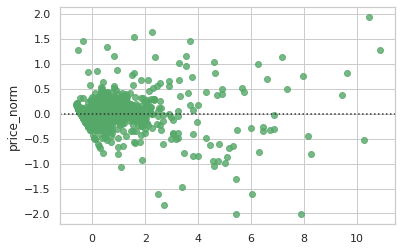

In [21]:
#Agora vamos fazer o MLP

model3  = MLPRegressor()
model3.fit(X_train, y_train)

predict = model3.predict(X_val)

mse3 = sklearn.metrics.mean_squared_error(y_val, predict)
r23 = r2_score(y_val, predict)
error_MAE3 = sklearn.metrics.mean_absolute_error(y_val, predict)

print("R2:      {:.3f}".format(r23))
print("MSE:     {:.3f}".format(mse3))
print("MAE:     {:.3f}".format(error_MAE3))

sns.set(style="whitegrid")
sns.residplot(predict, y_val, color="g")

In [22]:
#Agora vamos diminuir o erro do MLP no optuna
def mlpObjective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 4)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_{i}', 1, 100))
    with mlflow.start_run(experiment_id=experiment_id_MLP) as run:
      model = MLPRegressor(hidden_layer_sizes=tuple(layers))
      model.fit(X_train, y_train)
      y_pred = model.predict(X_val)
      error_MSE = sklearn.metrics.mean_squared_error(y_val, y_pred)
      error_MAE = sklearn.metrics.mean_absolute_error(y_val, y_pred)
      r2 = r2_score(y_val, predict)
      mlflow.log_param("layers", str(layers))
      mlflow.log_metric('mean_squared_error', error_MSE)
      mlflow.log_metric('mean_absolute_error', error_MAE)
      mlflow.log_metric('r2_score', r2)
      mlflow.end_run()
    return error_MSE

study = optuna.create_study(direction="minimize")
study.optimize(mlpObjective, n_trials=10)
print(study.best_trial)

[I 2020-11-15 15:18:00,872] A new study created in memory with name: no-name-22783e44-0d71-465e-9778-4dd91720c68e
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2020-11-15 15:18:04,151] Trial 0 finished with value: 0.044490585539407886 and parameters: {'n_layers': 1, 'n_units_0': 4}. Best is trial 0 with value: 0.044490585539407886.
[I 2020-11-15 15:18:07,911] Trial 1 finished with value: 0.039833535827004996 and parameters: {'n_layers': 1, 'n_units_0': 18}. Best is trial 1 with value: 0.039833535827004996.
[I 2020-11-15 15:18:13,176] Trial 2 finished with value: 0.8437409300199358 and parameters: {'n_layers': 3, 'n_units_0': 23, 'n_units_1': 92, 'n_units_2': 1}. Best is trial 1 with value: 0.039833535827004996.
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarni

FrozenTrial(number=8, value=0.030264757747751666, datetime_start=datetime.datetime(2020, 11, 15, 15, 18, 36, 498443), datetime_complete=datetime.datetime(2020, 11, 15, 15, 18, 46, 336247), params={'n_layers': 2, 'n_units_0': 85, 'n_units_1': 89}, distributions={'n_layers': IntUniformDistribution(high=4, low=1, step=1), 'n_units_0': IntUniformDistribution(high=100, low=1, step=1), 'n_units_1': IntUniformDistribution(high=100, low=1, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=8, state=TrialState.COMPLETE)
